# Chronos-2 Foundation Model
In this notebook, we will show how to use Chronos-2 in Darts. If you are new to Darts, please check out the [Quickstart Guide](https://unit8co.github.io/darts/quickstart/00-quickstart.html) before proceeding.

Chronos-2 is a time series foundation model for zero-shot forecasting. That means that it can be used for forecasting **without any training or fine-tuning** since it has already been pre-trained on large-scale time series data. Chronos-2 supports multivariate time series forecasting with [covariates](https://unit8co.github.io/darts/userguide/covariates.html) (exogenous variables) and can produce probabilistic forecasts.

Check out the [Amazon Science Blog](https://www.amazon.science/blog/introducing-chronos-2-from-univariate-to-universal-forecasting) and the [original paper](https://arxiv.org/abs/2510.15821) for technical details.

<div class="alert alert-success" role="alert">
  Fine-tuning Chronos-2 on your own data is not yet supported in Darts, but may be added in the future.
</div>

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from darts.datasets import ElectricityConsumptionZurichDataset
from darts.metrics import mae
from darts.models import Chronos2Model
from darts.utils.likelihood_models import QuantileRegression

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)
plt.style.use("ggplot")

## Data Preparation

Here, we will use the [Electricity Consumption Zurich Dataset](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ElectricityConsumptionZurichDataset), which records the electricity consumption of households & SMEs (`"Value_NE5"` column) and business & services (`"Value_NE7"`) in Zurich, Switzerland, along with weather covariates such as temperature (`"T [°C]"`) and humidity (`"Hr [%Hr]"`).
Values are recorded every 15 minutes between January 2015 and August 2022.

<details>

<summary><strong>Train-Test Split</strong></summary>

Even though Chronos-2 is pre-trained already, we still need to split the data into training and test sets. That is because `Chronos2Model` follows the Darts unified interface and will require calling the `fit()` method before forecasting. However, no training or fine-tuning will be performed during the `fit()` call.

</details>

<details>

<summary><strong>Data Scaling</strong></summary>

Unlike other deep learning models in Darts, Chronos-2 does not require data scaling since it has its own internal data normalization mechanism. Therefore, we will skip the scaling step in this notebook.

</details>

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = ElectricityConsumptionZurichDataset().load().astype(np.float32)
# extract households energy consumption
ts_energy = data["Value_NE5"]
# extract temperature, solar irradiation and rain duration
ts_weather = data[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]
# split into train and validation sets by last 7 days
train_energy, val_energy = ts_energy.split_before(len(ts_energy) - 7 * 24 * 4)

Let's quickly visualize the last 7 days of the electricity consumption data.

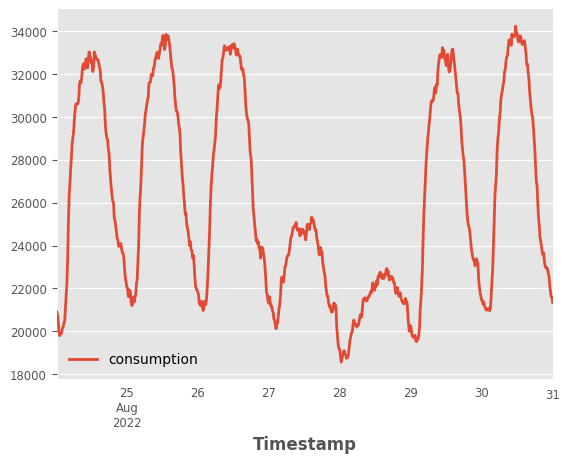

In [5]:
val_energy.plot(label="consumption");

## Model Creation

Chronos-2 supports two types of forecasting outputs:
- **Deterministic** forecasts (**default**): single point estimates for each future time step.
- **Probabilistic** forecasts: multiple samples for each future time step, which can be used to estimate prediction intervals. To enable probabilistic forecasting, set `likelihood=QuantileRegression([...])` when creating the model. The list of quantiles used here must be a subset of Chronos-2 supported quantiles: `[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]`.

<details>

<summary><strong>Lookback and Forward Windows</strong></summary>

Under the hood, Chronos-2 is no different from other [Torch Forecasting Models (TFMs)](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html) in Darts and most hyperparameters from TFMs can be applied here as well. In particular, you can control the length of the lookback window and the forward window using the `input_chunk_length` and `output_chunk_length` parameters, respectively.

- `input_chunk_length`: the number of time steps of history the model takes as input when making a forecast. Maximum is **8192** for Chronos-2.
- `output_chunk_length`: the number of time steps the model outputs in one forward pass. If the forecast horizon is longer than this value, the model consumes its own previous predictions to produce further forecasts. This is known as the autoregressive forecasting. Maximum is **1024** for Chronos-2.

![figure0](https://unit8co.github.io/darts/_images/tfm.png)

See the [Torch Forecasting Models User Guide](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html) for more details.

</details>

<details>

<summary><strong>Model Downloading and Caching</strong></summary>

When creating a `Chronos2Model` instance for the first time, the pre-trained model checkpoint will be automatically downloaded from [amazon/chronos-2](https://huggingface.co/amazon/chronos-2) hosted on Hugging Face Hub and cached locally. Subsequent usage of `Chronos2Model` will NOT re-download the files but use the cached version instead.

If you would like to download or load the model checkpoint to a custom directory, set `local_dir` argument when creating the model. For example:

```python
model = Chronos2Model(
    input_chunk_length=168,
    output_chunk_length=24,
    local_dir="path/to/your/directory"
)
```

</details>

<details>

<summary><strong>Using Other Checkpoints</strong></summary>

Other Chronos-2 checkpoints might be available in the future. You can specify a different checkpoint on Hugging Face Hub by setting the `hub_model_name` and `hub_model_revision` (optional) arguments when creating the model. For example:

```python
model = Chronos2Model(
    input_chunk_length=168,
    output_chunk_length=24,
    hub_model_name="amazon/chronos-2-some-other-checkpoint",
    hub_model_revision=None, # e.g., branch, tag, or commit ID
)
```

</details>

In [6]:
# use last 30 days of data to predict next 7 days
model = Chronos2Model(
    input_chunk_length=30 * 24 * 4,
    output_chunk_length=7 * 24 * 4,
)

## Model Training
Here, we will call the `fit()` method to "train" the model on the training set. Note that no actual training or fine-tuning will be performed since Chronos-2 is already pre-trained.

In [7]:
model.fit(
    series=train_energy,
    verbose=True,
)

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=2880, output_chunk_length=672)

## Forecasting
We now perform a one-shot forecast for the next 7 days using Chronos-2. We then compare the forecast against the actual values from the validation set.

Predicting: |          | 0/? [00:00<?, ?it/s]

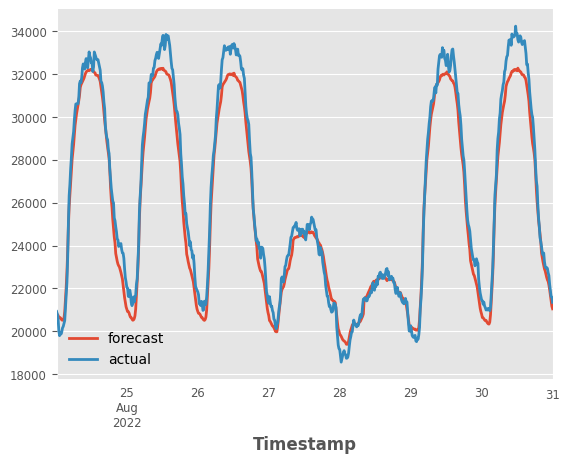

In [8]:
pred = model.predict(
    n=7 * 24 * 4,
    series=train_energy,
)
pred.plot(label="forecast")
val_energy.plot(label="actual");

You can see that Chronos-2 is able to produce qualitatively accurate forecasts without any training or fine-tuning!

In [9]:
mae_val = mae(val_energy, pred)
print(f"MAE on validation set: {mae_val:.2f}")

MAE on validation set: 653.57


## Forecasting with Covariates
Recall that Chronos-2 supports forecasting with covariates (exogenous variables). Since no training is required, we do not worry about hyperparameter tuning for covariates. Forecasting with covariates is as simple as passing the covariate series to the `fit()` and `predict()` methods!

We use weather variables as past covariates to help forecast the electricity consumption. We then compare the forecast (with and without covariates) against the actual values from the validation set.

Predicting: |          | 0/? [00:00<?, ?it/s]

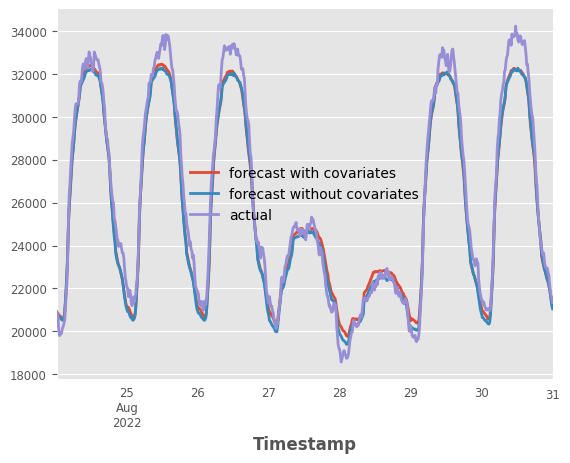

In [10]:
model = Chronos2Model(
    input_chunk_length=30 * 24 * 4,
    output_chunk_length=7 * 24 * 4,
)
model.fit(
    series=train_energy,
    past_covariates=ts_weather,
    verbose=True,
)
pred_cov = model.predict(
    n=7 * 24 * 4,
    series=train_energy,
    past_covariates=ts_weather,
)
pred_cov.plot(label="forecast with covariates")
pred.plot(label="forecast without covariates")
val_energy.plot(label="actual");

In [11]:
mae_cov = mae(val_energy, pred_cov)
print(f"MAE on validation set with covariates: {mae_cov:.2f}")

MAE on validation set with covariates: 662.96


## Probabilistic Forecasting
Here, we show how to perform probabilistic forecasting with Chronos-2 by using [`QuantileRegression`](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.sklearn.html#darts.utils.likelihood_models.sklearn.QuantileRegression) likelihood. The quantiles passed to `QuantileRegression` must be a subset of pre-trained quantiles supported by Chronos-2 (see "Model Creation" section above).

Because Darts apply Monte Carlo sampling to generate probabilistic forecasts, we recommend calling `predict()` with a higher `num_samples` value (e.g., 1000) to obtain more accurate quantile estimates. Alternatively, calling `predict()` with `predict_likelihood_parameters=True` will yield quantile estimates directly without sampling but auto-regressive forecasting will be disabled.

Predicting: |          | 0/? [00:00<?, ?it/s]

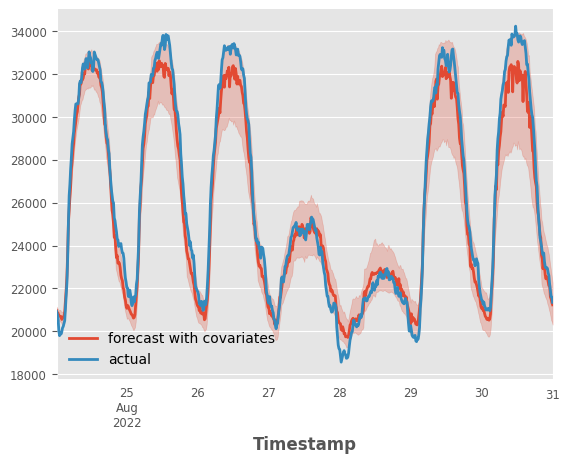

In [12]:
model = Chronos2Model(
    input_chunk_length=30 * 24 * 4,
    output_chunk_length=7 * 24 * 4,
    likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9]),
)
model.fit(
    series=train_energy,
    past_covariates=ts_weather,
    verbose=True,
)
pred_cov = model.predict(
    n=7 * 24 * 4,
    series=train_energy,
    past_covariates=ts_weather,
    num_samples=100,
)
pred_cov.plot(label="forecast with covariates")
val_energy.plot(label="actual");